In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os
import pandas as pd
import pybedtools as pbt
import statsmodels
import subprocess
import sys

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import config_readwrite as crw
import fet
import chr_functions
import split_filename

In [2]:
name = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configfile_name = crw.read_config(name)

SHUF_PATH = config["SHUFFLES"]["path"]
REGIONS = config["CIS_TRANS"]["regions"]
REGION_ANNOT = config["CIS_TRANS"]["regions_annotations"]

CL = "GM12878"

ID_TAG = config["TF_FOOTPRINTING_JASPAR"]["ID_TAG"]

print(ID_TAG)
FP_RE = config[f"TF_FOOTPRINTING_JASPAR_{CL}"]["FP"]
FP_OR_RE = config[f"TF_FOOTPRINTING_JASPAR_{CL}"]["FP_OR"] # write
FP_SHUF_OR_RE = config[f"TF_FOOTPRINTING_JASPAR_{CL}"]["FP_SHUF_OR"]  # write

FP_HH_OR_RE = config[f"TF_FOOTPRINTING_JASPAR_{CL}"]['FP_HH_OR']  # write
FP_MM_OR_RE = config[f"TF_FOOTPRINTING_JASPAR_{CL}"]['FP_MM_OR']  # write


RE = config["TF_FOOTPRINTING"]["results"]


path, region_file, region = split_filename.split_filename(REGIONS)

MA


In [3]:
fp = pd.read_csv(FP_RE, sep = '\t')

regions = pd.read_csv(REGION_ANNOT, sep ='\t',low_memory=False)

# Functions 

1. get sets of region ids for testing enrichment. 
2. get counts of FP in test regions v. FP not in test regions

In [4]:
def get_fp_counts(test, df):
    
    """
    return sets of region ids that overlap/do not overlap test column.
    """
    
    test_region_ids = set(df.loc[df[test]==1, "region_id"])
    nottest_region_ids = set(df.loc[df[test]!=1, "region_id"])
    
    return test_region_ids, nottest_region_ids

In [5]:
def make_2x2_among_active(test_tf, tf, ytest, ntest):
    """
    return counts of the number of TF FP that overlap the TE, TF FP that do not overlap a TE, 
    
    """
    
    if len(set(test_tf[tf]))>1:  # check that TF footprints at all. 

        # differential FP in yes test set?
        first_set = set(test_tf.loc[test_tf.region_id.isin(ytest), tf])
        
        if len(first_set)>1:

            b,a = test_tf.loc[test_tf.region_id.isin(ytest)].groupby(tf).count().reset_index().iloc[:, 1]
            
        elif False in first_set:
            b,a = len(ytest), 0  # all values are False in y set
        
        else:
            b,a = 0, len(ytest)  # all values are True in y set

        # differential FP in no test set?  
        second_set = set(test_tf.loc[test_tf.region_id.isin(ntest), tf])

        if len(second_set)>1:   
            d,c = test_tf.loc[test_tf.region_id.isin(ntest)].groupby(tf).count().reset_index().iloc[:, 1]

        elif False in second_set:
            d,c = len(ntest), 0  # all values are False in n set
            
        else:
            d,c = 0, len(ntest) # all values are True in n set
            
    else:
        a,b,c,d = 0,0,0,0
    
    return a,b,c,d
    

# make a list of TFs

In [6]:
#col = 'HH-active_MM-inactive_cis+trans'

tfs = list(fp)[4:]  #list of TF names to test

len(tfs)

746

# compare with shuffles
- this takes 6h to run!
- compare whether footprints are enriched in active categories v. flanking. 
- This is only 10 shuffles in flanking, sharedAccessible regions. 
- Not sure I would expect we would see a difference in TF footprinting between shuffles and active regions

In [8]:
test_cols = [ 
            "cis", "trans", 
           'HH-active_MM-inactive_MH-inactive_cis',
             'HH-active_MM-inactive_HM-inactive_trans',
             'HH-active_MM-inactive_cis-only',
             'HH-active_MM-inactive_trans-only',
             'HH-active_MM-inactive_cis+trans',
             'MM-active_HH-inactive_HM-inactive_cis',
             'MM-active_HH-inactive_MH-inactive_trans',
             'MM-active_HH-inactive_cis-only',
             'MM-active_HH-inactive_trans-only',
             'MM-active_HH-inactive_cis+trans',
            "cis_only",
            "trans_only", 
            "cis+trans"
                  ]
test_cols = [ 
           "conserved_active.regions"
                  ]

In [9]:
def run_OR(col, tfs, fp, regions, re):
    
    out = os.path.join(re, f"{col}_x_shuf_OR2.tsv")

    ytest, ntest = get_fp_counts(col, regions)
                       
    for i, tf in enumerate(tfs):
        print(tf)
        comparison = f"{col}_x_{tf}-shuf"

        test_tf = fp[["region_id", tf]].drop_duplicates()

        a,b,c,d = make_2x2_shufs(test_tf, tf, ytest)

        check_fp = a+b+c+d  # did footprint overlap any element?
        check_fp_n = a+c

        if check_fp>0 and check_fp_n>50:

            results = fet.get_2x2(a,b,c,d, comparison)
            results["arch_id"] = tf
            results["tested"] = col
            
            # write the results to a file. 
            if i==0:
                results.to_csv(out, sep = '\t', mode="a", index = False)
            else:
                results.to_csv(out, sep = '\t', mode="a", index = False, header = False)
    return out

In [10]:
def fdr_results(out):
    
    df = pd.read_csv(out, sep = '\t', nrows = 2)

    if "FDR_P" not in list(df):
    
        df = pd.read_csv(out, sep = '\t') # load full dataframe
        # get vector of p values
        pvals = df["P"]
    
        # run FDR correction at alpha = 0.05
        df["reject_null"], df["FDR_P"] = statsmodels.stats.multitest.fdrcorrection(pvals, alpha=0.05)

        # add an asterisks column
        df["asterisks"] = None
        df.loc[df["reject_null"]== True, "asterisks"] = "*"
    
        # add negative log ten p
        df['-log10p'] = np.log10(df["FDR_P"])*-1
        
        # re-write file
        df.to_csv(out, sep = '\t', index = False)
        
    else:
        print("already FDR corrected")
    

# Slurm jobs for shuffle enrichment

In [ ]:
#FP_SHUF_OR_RE = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/TF_footprinting/hu_footprinting_shuf_JASPAR_OR2.tsv"
if os.path.exists(FP_SHUF_OR_RE) is False:
    
    # run slurm job
    for col in test_cols:
        out = os.path.join(RE, f"{CL}-{col}_x_shuf_OR2.tsv")

        cmd = f"sbatch /data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/TF_FP/run_fp.slurm {col} {CL}"

        if os.path.exists(out) is False:
            subprocess.call(cmd, shell = True)

        else:
            numlines = sum(1 for line in open(out))
            if numlines< 746:

                subprocess.call(cmd, shell = True)
            else:
                print("already run", out)



# merge all the results together.  

In [20]:
merged =pd.read_csv(FP_SHUF_OR_RE, sep = '\t')

merged.head()

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,...,ci_lower_log2,ci_upper_log2,comparison,TF_id,tested,reject_null,FDR_P,asterisks,-log10p,TF
0,13,971,68,10756,2.117708,0.023081,1.165819,0.861160,3.846812,0.861160,...,0.221344,1.943663,MM-active_HH-inactive_cis-only_x_ATF3_MA0605.2...,ATF3_MA0605.2,MM-active_HH-inactive_cis-only,False,0.057955,NaN,1.236909,ATF3
1,22,962,174,10650,1.399742,0.150085,0.893964,0.646873,2.191675,0.646873,...,-0.161712,1.132034,MM-active_HH-inactive_cis-only_x_ARNT_MA0004.1...,ARNT_MA0004.1,MM-active_HH-inactive_cis-only,False,0.246441,NaN,0.608288,ARNT
2,9,975,81,10743,1.224274,0.563112,0.612978,0.998019,2.445188,0.998019,...,-0.706093,1.289945,MM-active_HH-inactive_cis-only_x_BHLHE40_MA046...,BHLHE40_MA0464.2,MM-active_HH-inactive_cis-only,False,0.674949,NaN,0.170729,BHLHE40
3,9,975,68,10756,1.460090,0.296246,0.726296,1.007429,2.935257,1.007429,...,-0.461371,1.553487,MM-active_HH-inactive_cis-only_x_GATA1_MA0035....,GATA1_MA0035.4,MM-active_HH-inactive_cis-only,False,0.408452,NaN,0.388859,GATA1
4,18,966,135,10689,1.475362,0.138394,0.898267,0.715853,2.423214,0.715853,...,-0.154783,1.276922,MM-active_HH-inactive_cis-only_x_RFX3_MA0798.2...,RFX3_MA0798.2,MM-active_HH-inactive_cis-only,False,0.232231,NaN,0.634080,RFX3


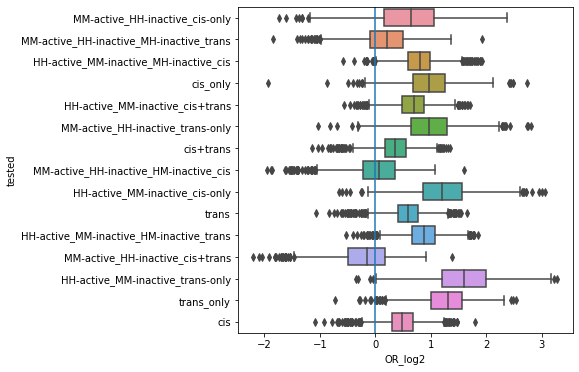

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(figsize = (6,6))
sns.boxplot(data= merged, y= "tested", x= "OR_log2" 
            )
ax.axvline(0)

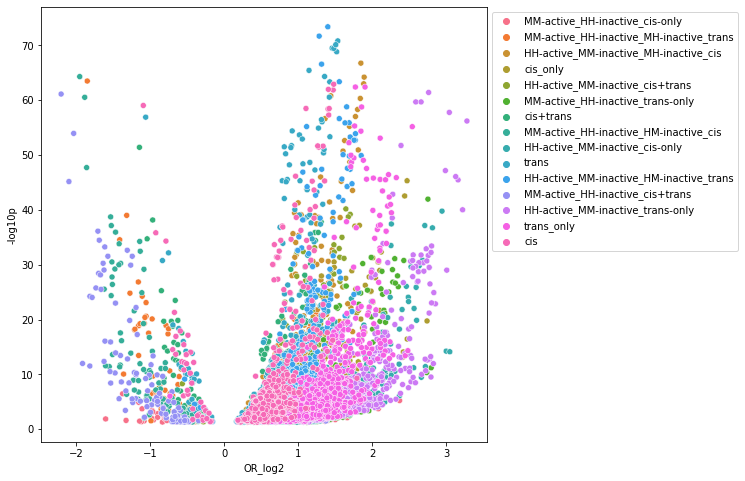

In [25]:
merged['-log10p'] = np.log10(merged["FDR_P"])*-1
x ="OR_log2" 
y="-log10p"
hue = "tested"
data = merged.loc[((merged["FDR_P"]<0.05))
                  #&(merged["OR_log2"]>0)
                 ]
fig, ax = plt.subplots(figsize =(8,8))
sns.scatterplot(x=x, y=y, data = data, hue=hue)
ax.legend(bbox_to_anchor = (1,1))
#ax.set(xlim = -)

# HH active, MM inactive 

In [26]:
merged.loc[(merged["FDR_P"]<0.05)]
merged['-log10p'] = np.log10(merged["FDR_P"])*-1